<a href="https://colab.research.google.com/github/oskar-paulsson/log-anomaly-detector/blob/master/inlamning4_umea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tomas Kommentar: 

Bra att du kört om experimenten ett större antal ggr så att man får lite statistik på körningarna. 

* Du har med de flesta moment vi frågar efter, men gör en lite väl kortfattad analys av dina resultat. 

* Dessutom så gör du vad jag kan se inte heller några direkta experiment med respektive utan RNN-regulariseringar, t.ex. dropout eller recurrent_dropout i RNN-lagren. 

* Totalt: Många delar är bra, **men vi saknar regulariseringsdelen** och vi vill att du **kompletterar med en sådan innan vid kan godkänna dig**. För omexaminationen så **skulle vi alltså vilja se en en analys av RNN-regulariseringar**, samt att du generellt gör en mer **ingående analys av dina resultat**.

# Recurrent Neural Networks, sunspot problem

Oskar Paulsson, guspauosa@student.gu.se

A lot of the code used in this notebook as been directly copied from Tomas' notebook as
most of what he's doing there is exactly what we want to achieve here aswell.

Import dependencies:

In [105]:
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

# Import needed libraries
import tensorflow.keras
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, TimeDistributed, RNN, InputLayer, Dropout, BatchNormalization, Conv1D, Flatten 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

print('Keras version:',tensorflow.keras.__version__)

# Helper libraries
import os
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics


# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

TensorFlow version: 2.3.0
Keras version: 2.4.0


In [106]:
# Test for GPU and determine what GPU we have
import sys
if not tf.config.list_physical_devices('GPU'):
     print("No GPU was detected. CNNs can be very slow without a GPU.")
     IN_COLAB = 'google.colab' in sys.modules
     if IN_COLAB:
         print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
     !nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-3a0cc171-63d2-e7a4-a5bc-5bd958ce3ad3)


In [107]:
# Read cvs file form SILSO website and set it up as a panda data structure.
webfile = 'http://www.sidc.be/silso/INFO/snmtotcsv.php' 
names = ['year', 'month', 'dec_year', 'sn_value' , 'sn_error', 'obs_num', 'def']
df = pd.read_csv(webfile,sep=';',header=None,names=names,na_values=['-1'], index_col=False)

In [108]:
# Function to plot time series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [109]:
# Print start and end of this data
print("Starting file:")
print(df[0:10])

print("Ending file:")
print(df[-10:])

Starting file:
   year  month  dec_year  sn_value  sn_error  obs_num  def
0  1749      1  1749.042      96.7       NaN       -1    1
1  1749      2  1749.123     104.3       NaN       -1    1
2  1749      3  1749.204     116.7       NaN       -1    1
3  1749      4  1749.288      92.8       NaN       -1    1
4  1749      5  1749.371     141.7       NaN       -1    1
5  1749      6  1749.455     139.2       NaN       -1    1
6  1749      7  1749.538     158.0       NaN       -1    1
7  1749      8  1749.623     110.5       NaN       -1    1
8  1749      9  1749.707     126.5       NaN       -1    1
9  1749     10  1749.790     125.8       NaN       -1    1
Ending file:
      year  month  dec_year  sn_value  sn_error  obs_num  def
3249  2019     10  2019.790       0.4       0.1     1065    1
3250  2019     11  2019.873       0.5       0.1      832    1
3251  2019     12  2019.958       1.5       0.5      855    1
3252  2020      1  2020.042       6.2       0.7      795    1
3253  2020   

[1749.455 1749.538 1749.623 ... 2020.288 2020.373 2020.455]
[139.2 158.  110.5 ...   5.4   0.2   5.8]
3259
3259
398.2


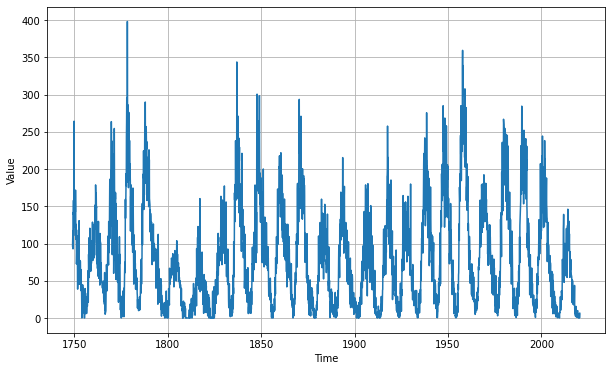

In [110]:
# Pick up the time (decimal date) and the sunspot series
series =df['sn_value'].to_numpy()
time = df['dec_year'].to_numpy()
maxval_sunspots = np.max(series)
print(time[5:-1])
print(series[5:-1])
print(len(time))
print(len(series))
print(maxval_sunspots)

plt.figure(figsize=(10, 6))
plot_series(time, series)

# Normalizing the data
In contrast with the mnist-datasets where we were working with pictures which were represented in a matrix as pixels with capped values, in this example and in other examples in the wild we might not have capped values. Here we're just using the prewritten code by Thomas to normalize the data but in theory we could
extract the maximum value of all the series that we're going to work on and normalize against that value.

In [111]:
# Scale data between 0-1
scaler = MinMaxScaler()
scale_val = series.reshape((len(series), 1)) # The scaler wants two dimensions of data (sequence and features)
scaler.fit(scale_val) # Set the scaling from training data
print("Max training value =", scaler.data_max_)

def toScale(invector):
  return scaler.transform(invector.reshape(-1, 1))[:,0]

def fromScale(invector):
  return scaler.inverse_transform(invector.reshape(-1, 1))[:,0]

# Now do the actual scaling
series = toScale(series)

Max training value = [398.2]


# Re-sizing the data before training
The input vector to an RNN needs to be of the 3-dimensional, with the 3 dimensions as follow:
* Samples
* Time Steps
* Features

Therefore we will resize our data by adding columns to the input vector.

Samples are the sequences we will feed into the network, 

time steps denotes how long the sequences should be, and

features is an intger denoting what the data might contain.


In [112]:
# Split a univariate sequence into samples with n_steps time steps
# from: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [113]:
n_steps    = 50 # How many steps will be at the input of the RNN
n_features = 1  # How many features the imput have (in this case it is just one, the number of sun spots)
# First split into sample sequences
sequence, sequence_out = split_sequence(series, n_steps)
# Then reshape from [samples, timesteps] into [samples, timesteps, features]
sequence = sequence.reshape((sequence.shape[0], sequence.shape[1], n_features))
# Now split up into training and test data
a = len(series)
test_cut = int(a*0.77) # Gives a split of 77/23

train_time = time[n_steps:test_cut+n_steps] 
train_seq = sequence[:test_cut]
train_out= sequence_out[:test_cut]
test_time = time[test_cut+n_steps:]
test_seq = sequence[test_cut:]
test_out = sequence_out[test_cut:]

In [114]:
# Check if I have problems with the sequence creation
print("Shape of train_seq:", train_seq.shape)
print("Shape of test_seq:", test_seq.shape)
print("Shape of test_out:", test_out.shape)
print("Last test_seq:", test_seq[1,:,0])
print("Last test_out:", test_out[1])

Shape of train_seq: (2509, 50, 1)
Shape of test_seq: (700, 50, 1)
Shape of test_out: (700,)
Last test_seq: [0.67805123 0.69713712 0.62330487 0.60999498 0.68056253 0.71195379
 0.71597187 0.64515319 0.54143646 0.66725264 0.77272727 0.50878955
 0.66047212 0.58086389 0.61175289 0.59994977 0.53214465 0.70969362
 0.51632346 0.39603214 0.44098443 0.44475138 0.52034154 0.376444
 0.3631341  0.43370166 0.42516323 0.39176293 0.43294827 0.47714716
 0.45228528 0.29457559 0.31868408 0.30436966 0.2061778  0.16423908
 0.18884982 0.21823204 0.18156705 0.27498744 0.24937217 0.19889503
 0.22626821 0.13485686 0.11677549 0.14289302 0.13837268 0.18006027
 0.16298343 0.16549473]
Last test_out: 0.15544952285283778


# Define baseline

In [115]:
predval = test_seq[:,-1,0]
# print(predval.shape)
rmse_baseline = np.sqrt(metrics.mean_squared_error(predval,test_out))
print("Baseline Test RMSE: %.4f" % rmse_baseline)

# If MAE is used
mae_baseline = np.mean(np.abs(predval - test_out))
print("Baseline Test MAE = %.3f" % mae_baseline )

Baseline Test RMSE: 0.0617
Baseline Test MAE = 0.044


# Define a simple model

Inspiration/code taken from Francois Chollet book "Hands on machine learning",
model taken from chapter 15. This model can predict one time step ahead at a time.

**Metrics**

Mean Absolute Error (MAE): Sums over the absolute value of differences between predicted output and the correct output. This is a measure of magnitude of the error, the lower value the better.

Mean Squared Error (MSE): The same principle is applied as with MAE but with MSE the the error increases quadratically which means it is a much more sensitive than MAE. Considering that data-points of sunspots are not well fitted to a line or curve, MSE might penalize too much and stop training prematurely, therefore this should be used with caution and with a high patience. 

Considering that the data is discrete, (a sun spot will be observed or it wont), very small residual errors (<1) will not occur, therefore MSE is likely to be very high. Thus we will focus on finding a model with optimal MAE. 

**Choosing a loss-function**:

MSE/MAE: *See above*

Huber: Combines the sensitivity of quadratic error with the robustness off absolute error.

In [116]:
model = Sequential()
# Using LSTM without activation function for fast training.
model.add(LSTM(50, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

opt = tf.keras.optimizers.Adam(lr=1e-3)

model.compile(loss='Huber', optimizer = opt, metrics=['mae'])

In [117]:
# Define an early-stopping callback function
monitor1 = EarlyStopping(monitor='mae', min_delta=0, patience=10, verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
#@title Train the first model
model0 = model
hist = model0.fit(train_seq, train_out, epochs=200, verbose=1, batch_size=32, validation_split = 0.2, callbacks=[monitor1])

Epoch 1/200
63/63 [==============================] - 1s 23ms/step - loss: 0.0052 - mae: 0.0725 - val_loss: 0.0035 - val_mae: 0.0625
Epoch 2/200
63/63 [==============================] - 1s 9ms/step - loss: 0.0027 - mae: 0.0520 - val_loss: 0.0030 - val_mae: 0.0582
Epoch 3/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0025 - mae: 0.0508 - val_loss: 0.0038 - val_mae: 0.0631
Epoch 4/200
63/63 [==============================] - 1s 9ms/step - loss: 0.0024 - mae: 0.0491 - val_loss: 0.0027 - val_mae: 0.0553
Epoch 5/200
63/63 [==============================] - 1s 9ms/step - loss: 0.0024 - mae: 0.0494 - val_loss: 0.0028 - val_mae: 0.0552
Epoch 6/200
63/63 [==============================] - 1s 9ms/step - loss: 0.0023 - mae: 0.0489 - val_loss: 0.0027 - val_mae: 0.0551
Epoch 7/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0023 - mae: 0.0492 - val_loss: 0.0027 - val_mae: 0.0550
Epoch 8/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0022

# Result, simple model

**Check model against baseline**

In [ ]:
v = model0.evaluate(x=test_seq, y=test_out, batch_size=32, verbose=1)

# If MAE is used
mae_model0 = v[1]
print("Baseline Test MAE : {}, model MAE was : {}".format(mae_baseline, mae_model0) )

23/23 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0394
Baseline Test MAE : 0.0440572137382679, model MAE was : 0.03935699164867401


In [ ]:
#@title Check model stability
#@markdown To see if the model is stable, i.e if the model produces the same results each time it is trained we will repeat the training + evaluation process many times successiely. 

REPETITIONS = 24
mae_model0_list = np.empty(REPETITIONS)
hist0 = []

for i in range(REPETITIONS):

  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(n_steps, n_features)))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(1))
  
  opt = tf.keras.optimizers.Adam(lr=1e-3)

  model.compile(loss='Huber', optimizer = opt, metrics = ['mae'])

  model0 = model
  hist0 = np.append(hist0, model0.fit(train_seq, train_out, epochs=200, verbose=0, batch_size=32, validation_split=0.2, callbacks=[monitor1]))

  v = model0.evaluate(x=test_seq, y=test_out, batch_size=32, verbose=0)

  # If MAE is used
  mae_model0_list[i] = v[1]

  print("Repetition # ", i)

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Repetition #  0
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Repetition #  1
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Repetition #  2
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Repetition #  3
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
Repetition #  4
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Repetition #  5
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Repetition #  6
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Repetition #  7
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Repetition #  8
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Repetition #  9


In [ ]:
#@title
best_mae0 = min(mae_model0_list)
avg_mae0 = np.mean(mae_model0_list)
med_mae0 = np.median(mae_model0_list)

biggest_diff0 = np.max(mae_model0_list) - np.min(mae_model0_list)

print("Biggest MAE diff : {}".format(biggest_diff0))
print("Baseline Test MAE : {}".format(mae_baseline))
print("Best model MAE was : {}".format(best_mae0))
print("Average model MAE was : {}".format(avg_mae0))
print("Median model MAE was : {}".format(med_mae0))
performance_rating0 = mae_baseline / avg_mae0
print("Performance rating (average MAE / baseline MAE) : {}".format(performance_rating0))

Biggest MAE diff : 0.00586763396859169
Baseline Test MAE : 0.0440572137382679
Best model MAE was : 0.0395536795258522
Average model MAE was : 0.041482571667681135
Median model MAE was : 0.041084131225943565
Performance rating (average MAE / baseline MAE) : 1.0620656330377092


**The model is slightly better than baseline in terms of MAE**

In [ ]:
#@title Model 1 with regularization 
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.25))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(1))

opt = tf.keras.optimizers.Adam(lr=1e-3)

model.compile(loss='Huber', optimizer = opt, metrics=['mae'])

model1 = model
hist1 = model1.fit(train_seq, train_out, epochs=200, verbose=1, batch_size=32, validation_split = 0.2, callbacks=[monitor1])

Epoch 1/200
63/63 [==============================] - 1s 22ms/step - loss: 0.0060 - mae: 0.0765 - val_loss: 0.0041 - val_mae: 0.0667
Epoch 2/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0031 - mae: 0.0562 - val_loss: 0.0031 - val_mae: 0.0593
Epoch 3/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0029 - mae: 0.0540 - val_loss: 0.0029 - val_mae: 0.0583
Epoch 4/200
63/63 [==============================] - 1s 9ms/step - loss: 0.0029 - mae: 0.0538 - val_loss: 0.0031 - val_mae: 0.0585
Epoch 5/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0028 - mae: 0.0531 - val_loss: 0.0028 - val_mae: 0.0569
Epoch 6/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0027 - mae: 0.0523 - val_loss: 0.0029 - val_mae: 0.0563
Epoch 7/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0026 - mae: 0.0514 - val_loss: 0.0029 - val_mae: 0.0586
Epoch 8/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0

In [ ]:
#@title
v = model1.evaluate(x=test_seq, y=test_out, batch_size=32, verbose=1)

# If MAE is used
mae_model1 = v[1]
print("Baseline Test MAE : {}, model MAE was : {}".format(mae_baseline, mae_model1) )

23/23 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0409
Baseline Test MAE : 0.0440572137382679, model MAE was : 0.040854066610336304


In [ ]:
#@title Statistical data from Model 1 with regularization

REPETITIONS = 24
mae_model1_list = np.empty(REPETITIONS)
hist1 = []

for i in range(REPETITIONS):

  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(n_steps, n_features)))
  model.add(Dropout(0.25))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dropout(0.25))
  model.add(Dense(1))

  opt = tf.keras.optimizers.Adam(lr=1e-3)

  model.compile(loss='Huber', optimizer = opt, metrics = ['mae'])

  model1 = model
  hist1 = np.append(hist1, model1.fit(train_seq, train_out, epochs=200, verbose=0, batch_size=32, validation_split=0.2, callbacks=[monitor1]))

  v = model1.evaluate(x=test_seq, y=test_out, batch_size=32, verbose=0)

  # If MAE is used
  mae_model1_list[i] = v[1]

  print("Repetition # ", i)

best_mae1 = min(mae_model1_list)
avg_mae1 = np.mean(mae_model1_list)
med_mae1 = np.median(mae_model1_list)
maxmin_mae1 = max(mae_model1_list) - min(mae_model1_list)

performance_rating1 =  mae_baseline / avg_mae1
print("Performance rating (average MAE / baseline MAE) : {}".format(performance_rating1))

print("Baseline Test MAE : {}".format(mae_baseline))
print("Best model MAE was : {}".format(best_mae1))
print("Average model MAE was : {}".format(avg_mae1))
print("Median model MAE was : {}".format(med_mae1))
print("Difference between minimum and maximum MAE : {}".format(maxmin_mae1))

Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Repetition #  0
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
Repetition #  1
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
Repetition #  2
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Repetition #  3
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Repetition #  4
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Repetition #  5
Restoring model weights from the end of the best epoch.
Epoch 00068: early stopping
Repetition #  6
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Repetition #  7
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Repetition #  8
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Repetition #  9


In [39]:
#@title Model 2

#@markdown To build upon, and improve the original model, we try adding a couple of 1D conv layer on top of the RNN-layers
model = Sequential()
model.add(Conv1D(64, padding='causal', activation='relu', kernel_size=2, input_shape=(n_steps, n_features) ))
model.add(Conv1D(128, padding='causal', activation='relu', kernel_size=4 ))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

opt = tf.keras.optimizers.Adam(lr=1e-3)

model.compile(loss='Huber', optimizer=opt, metrics=['mae'])

model2 = model
hist2 = model2.fit(train_seq, train_out, epochs=200, verbose=0, batch_size=32, validation_split=0.2, callbacks=[monitor1])

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping


In [ ]:
#@title Model 2 (without regularization), stability analysis run

REPETITIONS = 24
hist2 = []
mae_model2_list = np.zeros(REPETITIONS)

for i in range(REPETITIONS):  
  model = Sequential()
  model.add(Conv1D(64, padding='causal', activation='relu', kernel_size=2, input_shape=(n_steps, n_features) ))
  model.add(Conv1D(128, padding='causal', activation='relu', kernel_size=4 ))
  model.add(LSTM(50, return_sequences=True))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(1))

  opt = tf.keras.optimizers.Adam(lr=1e-3)

  model.compile(loss='Huber', optimizer=opt, metrics=['mse', 'mae'])

  model2 = model
  hist2 = np.append(hist2, model2.fit(train_seq, train_out, epochs=200, verbose=0, batch_size=32, validation_split=0.2, callbacks=[monitor1]))

  v = model2.evaluate(x=test_seq, y=test_out, batch_size=32, verbose=0)

  # If MAE is used
  mae_model2_list[i] = v[1]
  print("Repetition #",i)

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Repetition # 0
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Repetition # 1
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Repetition # 2
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
Repetition # 3
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Repetition # 4
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Repetition # 5
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Repetition # 6
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Repetition # 7
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Repetition # 8
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Repetition # 9
Restoring 

In [ ]:
#@title
maxmin_mae2 = max(mae_model2_list) - min(mae_model2_list)
print("MAE average %.4f" % np.average(mae_model2_list))
print("MAE median %.6f" % np.median(mae_model2_list))
print("MAE min %.6f" % np.min(mae_model2_list))
print("Difference between highest and lowest, MAE %.4f" % maxmin_mae2)
performance_rating2 = mae_baseline / np.average(mae_model2_list) 
print("Performance rating (average MAE / baseline MAE) : {}".format(performance_rating2))

MAE average 0.0032
MAE median 0.003146
MAE min 0.002998
Difference between highest and lowest, MAE 0.0010
Performance rating (average MAE / baseline MAE) : 13.623082566033865


In [ ]:
#@title Model 2, with regularization stability run
REPETITIONS = 24
hist3 = []
mae_model3_list = np.zeros(REPETITIONS)

for i in range(REPETITIONS):
  model = Sequential()

  model.add(Conv1D(64, padding='causal', activation='relu', kernel_size=2, input_shape=(n_steps, n_features) ))
  model.add(Dropout(0.25))

  model.add(Conv1D(128, padding='causal', activation='relu', kernel_size=4 ))
  model.add(Dropout(0.25))
  model.add(BatchNormalization())

  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.25))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dropout(0.25))
  model.add(Dense(1))

  opt = tf.keras.optimizers.Adam(lr=1e-3)

  model.compile(loss='Huber', optimizer=opt, metrics=['mae'])

  model3 = model
  hist3 = np.append(hist3, model3.fit(train_seq, train_out, epochs=200, verbose=0, batch_size=32, validation_split=0.2, callbacks=[monitor1]))
  v = model3.evaluate(x=test_seq, y=test_out, batch_size=32, verbose=0)
  # If MAE is used
  mae_model3_list[i] = v[1]
  print("Repetition #", i)

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Repetition # 0
Restoring model weights from the end of the best epoch.
Epoch 00068: early stopping
Repetition # 1
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
Repetition # 2
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping
Repetition # 3
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
Repetition # 4
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Repetition # 5
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Repetition # 6
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
Repetition # 7
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Repetition # 8
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
Repetition # 9
Restoring 

In [ ]:
#@title
maxmin_mae3 = max(mae_model3_list) - min(mae_model3_list)
print("MAE average %.4f" % np.average(mae_model3_list))
print("MAE median %.6f" % np.median(mae_model3_list))
print("MAE min %.6f" % np.min(mae_model3_list))
print("Difference between highest and lowest, MAE %.4f" % maxmin_mae3)
performance_rating3 = mae_baseline / np.average(mae_model3_list)
print("Performance rating (average MAE / baseline MAE) : {}".format(performance_rating3))

MAE average 0.0436
MAE median 0.042658
MAE min 0.040596
Difference between highest and lowest, MAE 0.0136
Performance rating (average MAE / baseline MAE) : 1.0095058676650657


# Model 1 and 2 side by side

>--- | Model 1 | --- | --- | --- | --- | Model 2 | --- | --- | --- | --- |
>--- | --- | --- | --- | ---- | --- | --- | --- | --- | --- | --- |
>--- | Best MAE | Average MAE | Median MAE | MAE Diff | Rating | Best MAE |Average MAE| Median MAE | MAE Diff | Rating 
>No Regularization | 0.0396 | 0.0415 | 0.0411 | 0.0059 | 1.06 | **0.0030** | 0.0032 | 0.0031 | 0.0010 | **13.62** |
>Regularization| 0.0399 | 0.0410 | 0.0408 | 0.0040 | 1.07 | 0.0406 | 0.0436 | 0.0427 | 0.0136 | 1.01

From the table above we can conclude that all models except model 2 with regularization out perform the baseline. Model 2 performs exceptionally well w.r.t. baseline with a rating of being 13 times better than baseline.

The "rating" is defined by : ```r = baseline_mae / average_mae_for_model_x```


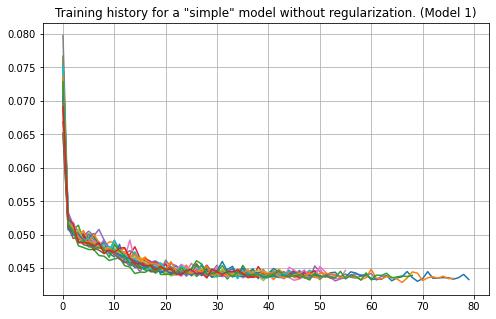

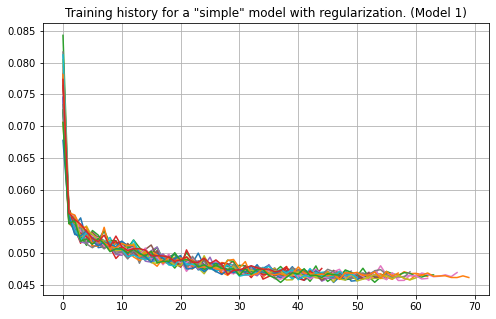

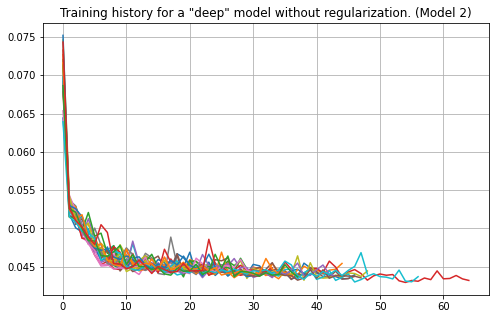

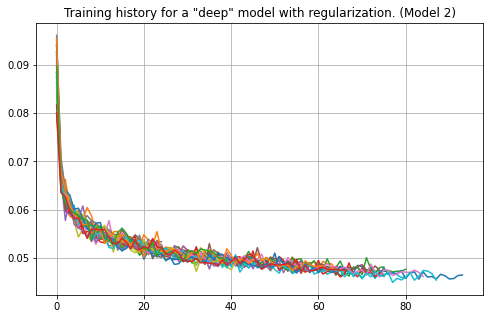

In [ ]:
#@title Training history from all models below
#@markdown From these plots we can see two distinct behaviors for models with/without regularization.
#@markdown Curves of the models without regularization seems to be more "noisy" with the MAE going up and 
#@markdown down more as training proceeds over the epochs. 
#@markdown The models without regularization also tend to go down close to their minimal MAE quicker 
#@markdown and then do not improve _significantly_, while models with regularization 
#@markdown look like they get MAE-values that decrease linearily over the epochs. 
#@markdown This is especially noticable in the last plot. 

for HIST in hist0:
  # Plot training history
  pd.DataFrame(HIST.history)['mae'].plot(figsize=(8, 5))
  plt.grid(True)
  
plt.title("Training history for a \"simple\" model without regularization. (Model 1)")
plt.show()

for HIST in hist1:
  # Plot training history
  pd.DataFrame(HIST.history)['mae'].plot(figsize=(8, 5))
  plt.grid(True)
  
plt.title("Training history for a \"simple\" model with regularization. (Model 1)")
plt.show()

for HIST in hist2:
  # Plot training history
  pd.DataFrame(HIST.history)['mae'].plot(figsize=(8, 5))
  plt.grid(True)
  
plt.title("Training history for a \"deep\" model without regularization. (Model 2)")
plt.show()

for HIST in hist3:
  # Plot training history
  pd.DataFrame(HIST.history)['mae'].plot(figsize=(8, 5))
  plt.grid(True)
  
plt.title("Training history for a \"deep\" model with regularization. (Model 2)")
plt.show()

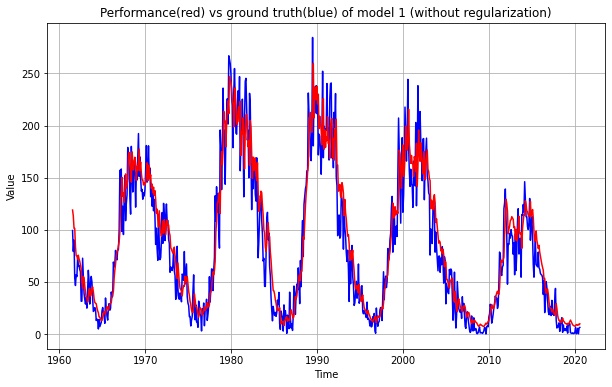

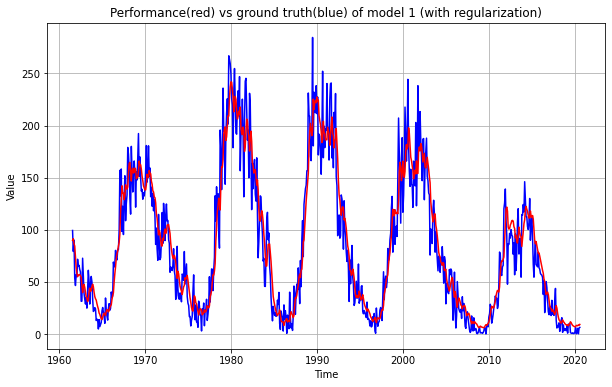

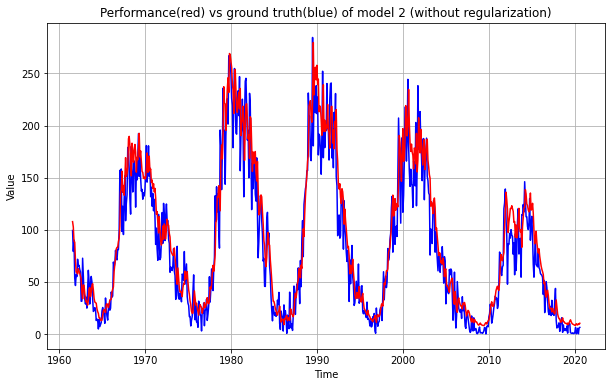

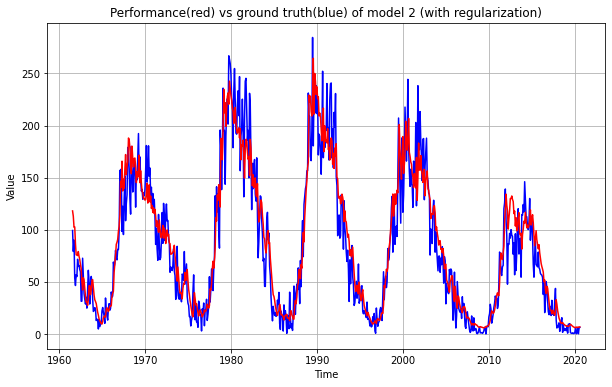

In [ ]:
#@title Comparison with ground truth
#@markdown The plots below show the test sequence in blue, which was not used during training or validation 
#@markdown against the predictions of the model on the time scale of the test sequence in red. The third figure
#@markdown shows that the best model (model 2 without regularization) is able to very closely predict/model
#@markdown ground truth of the timeseries.  

eval_output = model0.predict(test_seq)
plt.figure(figsize=(10, 6))
plot_series(test_time, fromScale(test_out), format="-b")
plot_series(test_time, fromScale(eval_output), format="-r")
plt.title("Performance(red) vs ground truth(blue) of model 1 (without regularization)")
plt.show()

eval_output = model1.predict(test_seq)
plt.figure(figsize=(10, 6))
plot_series(test_time, fromScale(test_out), format="-b")
plot_series(test_time, fromScale(eval_output), format="-r")
plt.title("Performance(red) vs ground truth(blue) of model 1 (with regularization)")
plt.show()

eval_output = model2.predict(test_seq)
plt.figure(figsize=(10, 6))
plot_series(test_time, fromScale(test_out), format="-b")
plot_series(test_time, fromScale(eval_output), format="-r")
plt.title("Performance(red) vs ground truth(blue) of model 2 (without regularization)")
plt.show()

eval_output = model3.predict(test_seq)
plt.figure(figsize=(10, 6))
plot_series(test_time, fromScale(test_out), format="-b")
plot_series(test_time, fromScale(eval_output), format="-r")
plt.title("Performance(red) vs ground truth(blue) of model 2 (with regularization)")
plt.show()

# Conclusions on using regularization and simple vs deep models
We could very significantly increase the performance of the simple model (two LSTM's) by adding a couple of convolutional layers. In the case of a simple model, regularization did not improve performance and in the case of the "deeper" model regularization hurt performance significantly. 

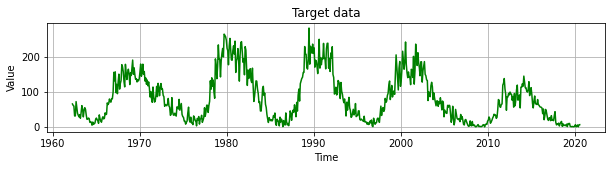

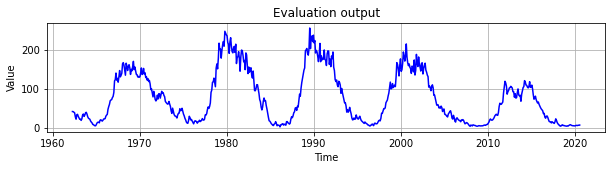

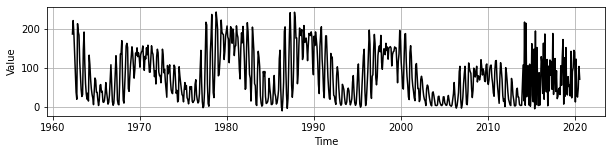

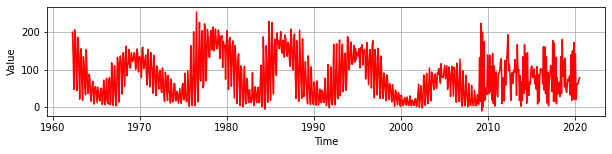

In [82]:
#@title Predicting 10 steps ahead
#@markdown In the following wek take output of ```model2.predict(test_seq)```, append it to ```test_seq```
#@markdown and then feed it back to the ```predict```-function in 10 iterations. 
eval_output = model2.predict(test_seq)
new_test_seq = np.append(test_seq[:,-49:,0], eval_output).reshape(700,50,1)
test_time_new = test_time
end = test_time[len(test_time)-1]
h = np.average(np.gradient(test_time))

plt.figure(figsize=(10, 2))
plot_series(test_time, fromScale(test_out), format="-g")
plt.title("Target data")

plt.figure(figsize=(10, 2))
plot_series(test_time, fromScale(eval_output), format="-b")
plt.title("Evaluation output")


for i in range(0,10):
  new_test_seq = np.append(new_test_seq[:,-49:,0], eval_output).reshape(700,50,1)
  eval_output = model2.predict(new_test_seq)
  test_time_new = np.append(test_time_new, end + h*(i+1))
  if i == 4:
    plt.figure(figsize=(10, 2))
    plot_series(test_time, fromScale(eval_output), format="-k")    

plt.figure(figsize=(10, 2))
plot_series(test_time, fromScale(eval_output), format="-r")

The first plot (blue) shows the prediction by the network when using the original test sequence. In the following, we make a prediction and append the output to the test sequence, thus altering input to the model with each iteration and repeat these steps 10 times. The plots in black and red show the evaluation output at 5 and 10 iterations respectively.

The result is that predictions become more and more noisy with each iteration. Considering that even the first output is bound to have some bad predictions, so feeding the model successively more noisy input is granted to give a successively worse output. Figure 1, 2 and 3 shows this progression in 3 steps. 

# Training a model to predict 10 steps a head

This is done by changing the number of nodes in the the output layer from 1 to 10.

In [78]:
model = Sequential()
model.add(Conv1D(64, padding='causal', activation='relu', kernel_size=2, input_shape=(n_steps, n_features) ))
model.add(Conv1D(128, padding='causal', activation='relu', kernel_size=4 ))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(10))

opt = tf.keras.optimizers.Adam(lr=1e-3)

model.compile(loss='Huber', optimizer=opt, metrics=['mae'])

model_10steps = model
model_10steps.fit(train_seq, train_out, epochs=200, verbose=0, batch_size=32, validation_split=0.2, callbacks=[monitor1])

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping


Text(0.5, 1.0, 'Training sequence (blue) and evaluation output (green)')

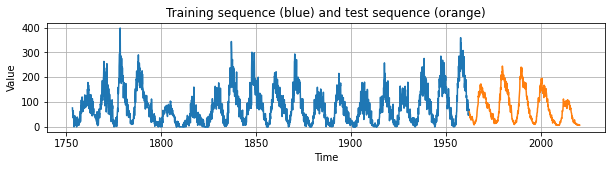

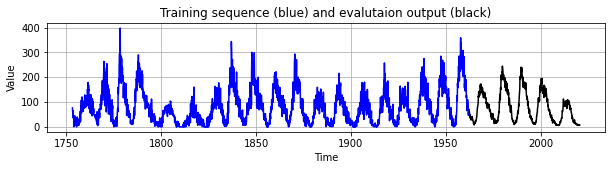

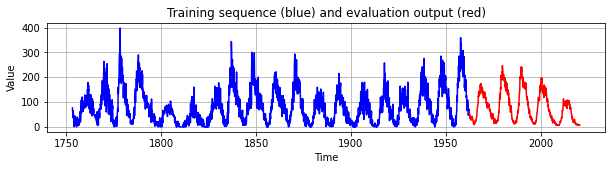

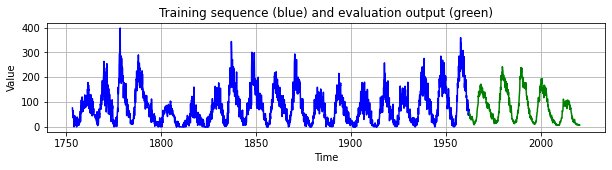

In [64]:
#@title Evaluating the 10 step model
#@markdown Below we show the results of the 10-step model, displaying the intermittent steps 1, 5 and 10 of the output
#@markdown from ```  ``` 
out_10steps = model_10steps.predict(test_seq).reshape(700,10,1)

new_test_seq = np.append(test_seq[:,-40:,0],out_10steps).reshape(700,50,1)

out_10steps_new = model_10steps.predict(new_test_seq)

new_new_test_seq = np.append(new_test_seq[:,-40:,0],out_10steps_new).reshape(700,50,1)

out_10steps_new_new = model_10steps.predict(new_new_test_seq)

plt.figure(figsize=(10, 2))
plot_series(train_time, fromScale(train_out),)
plot_series(test_time, fromScale(out_10steps[:,0]), )
plt.title("Training sequence (blue) and test sequence (orange)")

plt.figure(figsize=(10, 2))
plot_series(train_time, fromScale(train_out), format="-b", )
plot_series(test_time, fromScale(out_10steps[:,0]), format="-k", )
plt.title("Training sequence (blue) and evalutaion output (black)")

plt.figure(figsize=(10, 2))
plot_series(train_time, fromScale(train_out), format="-b", )
plot_series(test_time, fromScale(out_10steps[:,4]), format="-r", )
plt.title("Training sequence (blue) and evaluation output (red)")

plt.figure(figsize=(10, 2))
plot_series(train_time, fromScale(train_out), format="-b", )
plot_series(test_time, fromScale(out_10steps[:,9]), format="-g", )
plt.title("Training sequence (blue) and evaluation output (green)")

#### **Conclusion, 10-step model**

Using a model which is intended to predict 10 steps ahead instead of just one gave no distorting or destruction effect as seen in the 1-step model above, however note that all steps look exactly the same! See below graph:

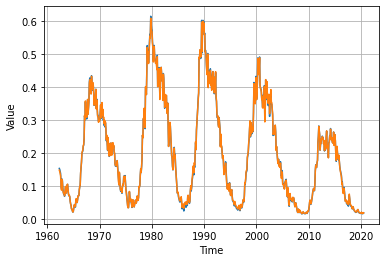

In [75]:
for i in [0, 9]:
  plot_series(test_time,out_10steps[:,i])

All of the 10 steps predicted by our 10-step model are overlayed in the same graph, they are all the same! Therefore it seems like the model cannot predict "evolution" of the dataset but can really only **reproduce** whatever we feed it

In [118]:
model = Sequential()
model.add(Conv1D(64, padding='causal', activation='relu', kernel_size=2, input_shape=(n_steps, n_features) ))
model.add(Conv1D(128, padding='causal', activation='relu', kernel_size=4 ))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(keras.layers.TimeDistributed(Dense(1)))

opt = tf.keras.optimizers.Adam(lr=1e-3)

model.compile(loss='Huber', optimizer=opt, metrics=['mae'])

model_1steps_td = model
model_1steps_td.fit(train_seq, train_out, epochs=200, verbose=0, validation_split=0.2, callbacks=[monitor1])

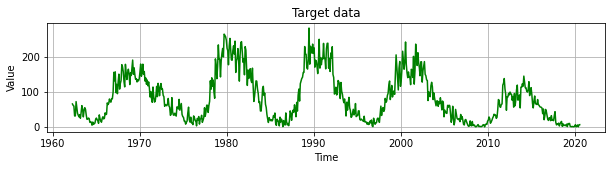

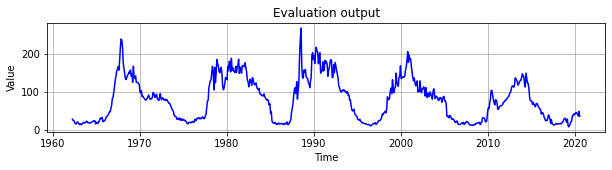

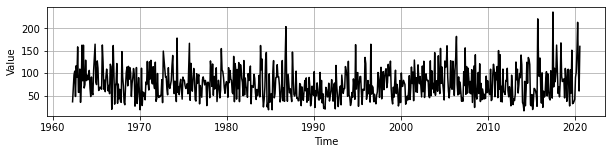

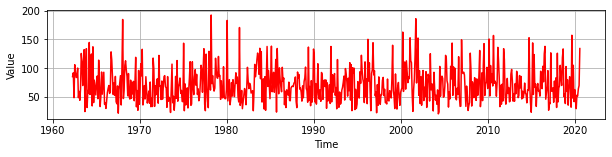

In [102]:
eval_output = model_1steps_td.predict(test_seq)
new_test_seq =  (eval_output).reshape(700,50,1)
test_time_new = test_time
end = test_time[len(test_time)-1]
h = np.average(np.gradient(test_time))

plt.figure(figsize=(10, 2))
plot_series(test_time, fromScale(test_out), format="-g")
plt.title("Target data")

plt.figure(figsize=(10, 2))
plot_series(test_time, fromScale(eval_output[:,49]), format="-b")
plt.title("Evaluation output")

for i in range(0,10):
  new_test_seq = (eval_output).reshape(700,50,1)
  eval_output = model_1steps_td.predict(new_test_seq)
  test_time_new = np.append(test_time_new, end + h*(i+1))
  if i == 4:
    plt.figure(figsize=(10, 2))
    plot_series(test_time, fromScale(eval_output[:,49]), format="-k")    

plt.figure(figsize=(10, 2))
plot_series(test_time, fromScale(eval_output[:,49]), format="-r")

In [ ]:
model = Sequential()
model.add(Conv1D(64, padding='causal', activation='relu', kernel_size=2, input_shape=(n_steps, n_features) ))
model.add(Conv1D(128, padding='causal', activation='relu', kernel_size=4 ))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(50))

opt = tf.keras.optimizers.Adam(lr=1e-3)

model.compile(loss='Huber', optimizer=opt, metrics=['mae'])

model_50steps = model
model_50steps.fit(train_seq, train_out, epochs=200, verbose=0, batch_size=32, validation_split=0.2, callbacks=[monitor1])

In [32]:
out_50steps = model_50steps.predict(test_seq).reshape(709,50,1)
new_seq = np.append(test_seq[:,-90:,0], out_50steps).reshape(709,100,1)
plt.figure(figsize=(14, 6))
plot_series(time, fromScale(series), format="-b", )
plot_series((709)*h+test_time, fromScale(new_seq[:,0]), format="-r", )

NameError: ignored

The two results are both quite inaccurate and in-credible as predictors of future sun-weather. It is clear from the data that we have there is some peroidicity to the amount to observed sunspots. While the step-by-step prediction looks like a sort of static, random predictor - the network that is trained to predict 10 steps ahead from a given time shows results more akin to the test-data. 

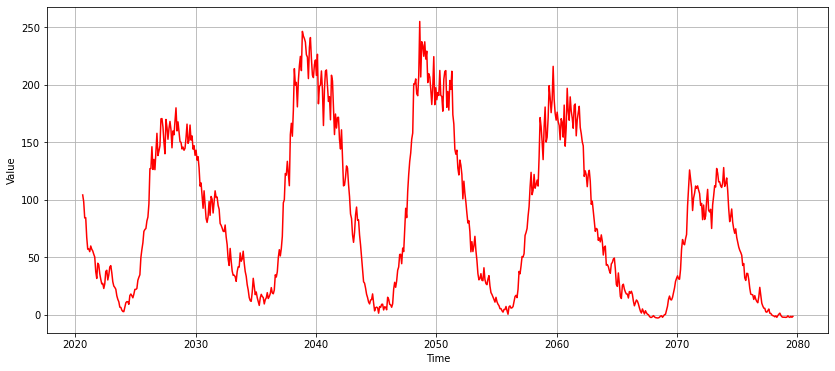

In [ ]:
out_100steps = model_100steps.predict(test_seq).reshape(709,100,1)
# new_seq = np.append(test_seq[:,-40:,0], out_10steps).reshape(709,50,1)
t = []
eval_output = model2.predict(test_seq)
for i in range(709):
  t = np.append(t, end + (i+1)*h)
plt.figure(figsize=(14, 6))
plot_series(t, fromScale(eval_output[:,0]), format="-r", )

In [ ]:
eval_output = model2.predict(test_seq)

In [ ]:
eval_output.shape

(709, 1)

# GRU vs LSTM

In [ ]:
model = Sequential()
model.add(Conv1D(64, padding='causal', activation='relu', kernel_size=2, input_shape=(n_steps, n_features) ))
model.add(Conv1D(128, padding='causal', activation='relu', kernel_size=4 ))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(10, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(lr=1e-3)

model.compile(loss='mae', optimizer=opt, metrics=['mse', 'mae'])

modelLSTM = model
modelLSTM_hist = modelLSTM.fit(train_seq, train_out, epochs=250, verbose=0, batch_size=32, validation_split=0.2, callbacks=[monitor1])
eval_LSTM = modelLSTM.evaluate(x=test_seq, y=test_out, batch_size=32, verbose=1)

Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
23/23 [==============================] - 0s 5ms/step - loss: 0.0392 - mse: 0.0031 - mae: 0.0392


In [ ]:
model = Sequential()
model.add(Conv1D(64, padding='causal', activation='relu', kernel_size=2, input_shape=(n_steps, n_features) ))
model.add(Conv1D(128, padding='causal', activation='relu', kernel_size=4 ))
model.add(GRU(50, return_sequences=True))
model.add(GRU(50, return_sequences=False))
model.add(Dense(10, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(lr=1e-3)

model.compile(loss='mae', optimizer=opt, metrics=['mse', 'mae'])

modelGRU = model
modelGRU_hist = modelGRU.fit(train_seq, train_out, epochs=250, verbose=0, batch_size=32, validation_split=0.2, callbacks=[monitor1])
eval_GRU = modelGRU.evaluate(x=test_seq, y=test_out, batch_size=32, verbose=1)

Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
23/23 [==============================] - 0s 5ms/step - loss: 0.0390 - mse: 0.0030 - mae: 0.0390


In [ ]:
out_10stepsLSTM = modelLSTM.predict(test_seq).reshape(709,10,1)
new_seq = np.append(test_seq[:,-40:,0], out_10stepsLSTM).reshape(709,50,1)
print(new_seq.shape)
plt.figure(figsize=(14, 6))
plot_series(test_time, fromScale(new_seq[:,49]), format="-r", )

NameError: ignored

(709, 50, 1)


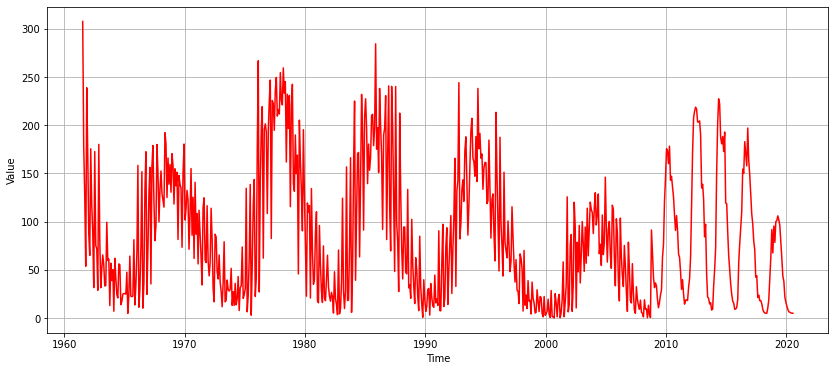

In [ ]:
out_10stepsGRU = modelGRU.predict(test_seq).reshape(709,10,1)
new_seq = np.append(test_seq[:,-40:,0], out_10stepsGRU).reshape(709,50,1)
print(new_seq.shape)
plt.figure(figsize=(14, 6))
plot_series(test_time, fromScale(new_seq[:,49]), format="-r", )

The performance of the GRU-model and the LSTM model is virtually indistinguishable

In [67]:
test_seq.shape
_test_series_test = test_seq.reshape(700*50,1)

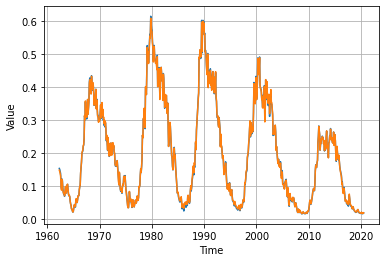

In [73]:
for i in [0, 9]:
  plot_series(test_time,out_10steps[:,i])